<a href="https://colab.research.google.com/github/Arseniy-Polyakov/Python_Course/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22denoising_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Задаем априорное распределение**

Распределение Гаусса предсказывает поведение случайной величины

Если для каждой единицы, например, для одного *пикселя изображения* предсказать его величину (глубину цвета, насыщенность чёрного...) на основе нормального распределения, получится равномерный шум

In [ ]:
import torch

noise = torch.randn(128, 128)
noise

tensor([[-1.0099,  1.1450, -0.5218,  ..., -0.6766,  0.3085,  1.9983],
        [ 1.0400, -0.7795, -1.0827,  ..., -0.2642,  0.6133,  1.4501],
        [-1.2587, -0.5482, -1.6482,  ..., -2.1063, -1.4542,  0.5993],
        ...,
        [-0.2069,  0.5710, -0.1324,  ..., -0.1726,  0.0672, -0.0205],
        [-0.5594,  0.5856, -0.2552,  ...,  0.3646, -0.9660, -0.1020],
        [ 0.7184, -1.6003,  0.9031,  ...,  0.0083, -0.4705,  0.9550]])

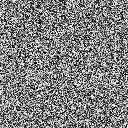

In [ ]:
import torchvision.transforms as transforms

trans = transforms.ToPILImage()
out = trans(noise)
out

**2. MNIST**

In [ ]:
import torchvision.datasets as datasets

# датасет MNIST для обучения модели
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 430kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

**3. Функции для нойзинга и денойзинга**

In [ ]:
# генерация случайного шума:
# параметры: размер батча и количество инпутов модели скрытой диффузии
def generate_noise(batch_size, latent_size):
    return torch.randn(batch_size, latent_size)

# денойзинг: x = шум, y = изображение из датасета
def denoise_image(image, model):
    return model(image)

**4. Модель скрытой диффузии**

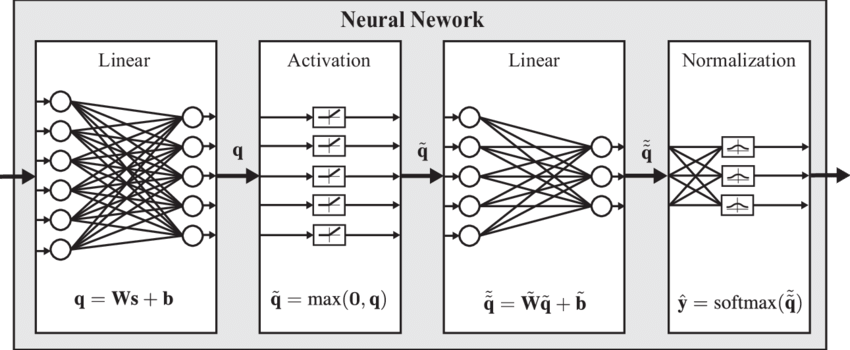

In [ ]:
import torch.nn as nn

class LatentDiffusion(nn.Module):
    def __init__(self):
        super(LatentDiffusion, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 256), # аргументы: количество инпутов (latent_size)
            nn.ReLU(), # функция активации между слоями; отсекает значения < 0
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() # выходная функция активации, значения от 0 до 1
        )

    def forward(self, z): # форвард-пасс для обратного распространения ошибки
        return self.model(z)

**5. Гиперпараметры**

Про алгоритмы оптимизации

- помогают не застрять в **локальных** минимумах
- идея любого алогритма оптимизации заключается в подроборе оптимального **шага оптимального размера** при градиентном спуске
- **Adam** - это адаптивный алгоритм, который вычисляет взвешенное среднее текущего и предыдущего значения градиентов и весов

In [ ]:
import torch.optim as optim

# параметры обучения
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# инициализация модели
latent_diffusion_model = LatentDiffusion()

# алгоритм оптимизации
optimizer = optim.Adam(latent_diffusion_model.parameters(), lr=0.001)

# количество эпох
num_epochs = 1

**6. Обучаем**

In [ ]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # приводим изображения к виду одномерных векторов (flatten)
        images = images.view(images.size(0), -1)

        # зашумливаем изображение
        noise = generate_noise(images.size(0), 784)  # размер матрицы = размер изображения

        # производим денойзинг: передаем шум в модель
        denoised_images = denoise_image(noise, latent_diffusion_model)

        # считаем потери
        loss = nn.MSELoss()(denoised_images, images)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # выводим отчет об обучении
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [100/938], Loss: 0.0630
Epoch [1/1], Step [200/938], Loss: 0.0651
Epoch [1/1], Step [300/938], Loss: 0.0698
Epoch [1/1], Step [400/938], Loss: 0.0645
Epoch [1/1], Step [500/938], Loss: 0.0677
Epoch [1/1], Step [600/938], Loss: 0.0704
Epoch [1/1], Step [700/938], Loss: 0.0689
Epoch [1/1], Step [800/938], Loss: 0.0725
Epoch [1/1], Step [900/938], Loss: 0.0672


**7. Тестируем модель**

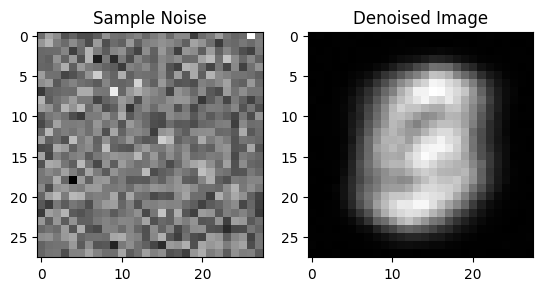

In [ ]:
import matplotlib.pyplot as plt

# создаем случайный шум и передаем его обученной модели
sample_noise = generate_noise(1, 784)
sample_denoised_image = denoise_image(sample_noise, latent_diffusion_model)

# выводим на экран шум и то, что модель дешифровала с помощью обученных весов
plt.subplot(1, 2, 1)
plt.imshow(sample_noise.view(28, 28).detach().numpy(), cmap='gray')
plt.title('Sample Noise')

plt.subplot(1, 2, 2)
plt.imshow(sample_denoised_image.view(28, 28).detach().numpy(), cmap='gray')
plt.title('Denoised Image')

plt.show()